In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

df = pd.read_csv("accidents_2017_to_2023_portugues.csv")

df = df.dropna(subset=["dia_semana", "causa_acidente", "horario"])
df["dia_semana"] = df["dia_semana"].str.strip().str.lower()
df["causa_acidente"] = df["causa_acidente"].str.strip().str.lower()
df["final_semana"] = df["dia_semana"].isin(["sábado", "domingo"])

df["causa_categoria"] = df["causa_acidente"].apply(
    lambda x: "Álcool" if "álcool" in x
    else "Fadiga" if "dormindo" in x
    else "Outras"
)

# Paleta de cores
paleta_azul = sns.color_palette("Blues", n_colors=3)

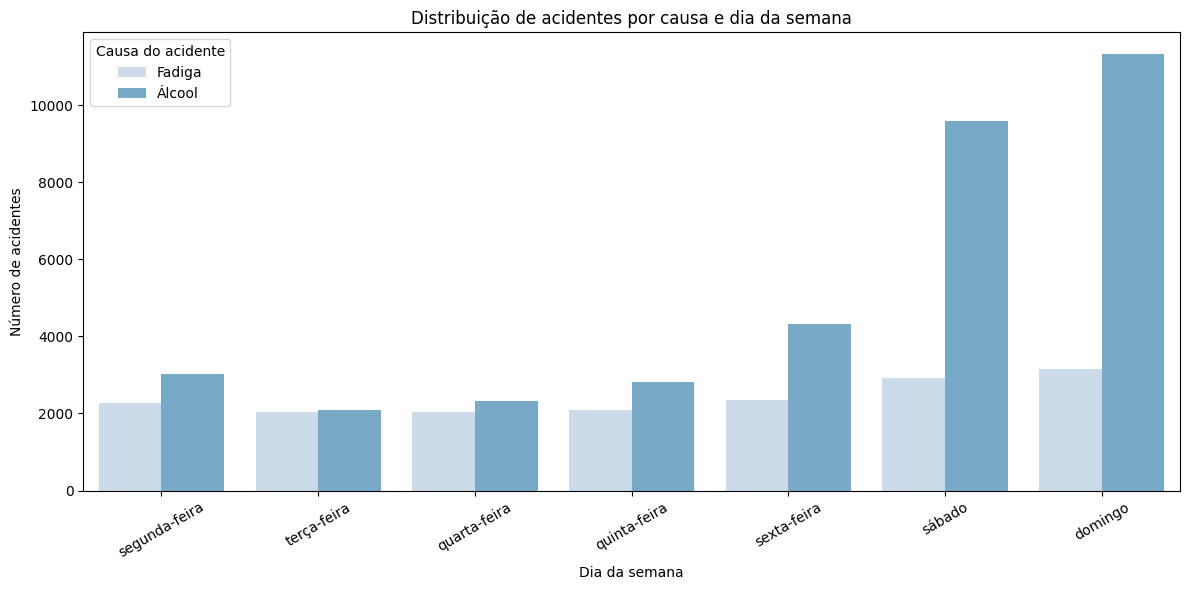

In [30]:
plt.figure(figsize=(12,6))
sns.countplot(
    data=df[df["causa_categoria"] != "Outras"],
    x="dia_semana",
    hue="causa_categoria",
    palette=paleta_azul[:2],
    order=["segunda-feira","terça-feira","quarta-feira","quinta-feira","sexta-feira","sábado","domingo"]
)
plt.title("Distribuição de acidentes por causa e dia da semana")
plt.xlabel("Dia da semana")
plt.ylabel("Número de acidentes")
plt.legend(title="Causa do acidente")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

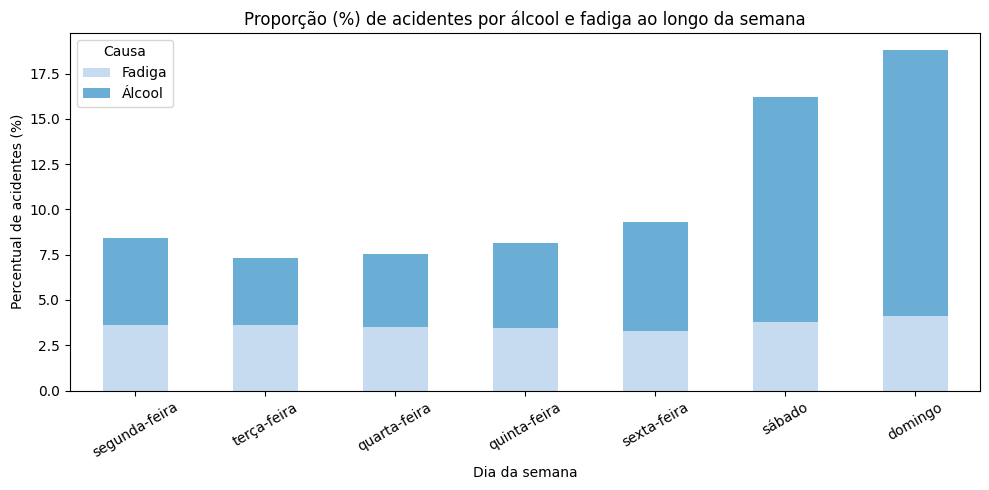

In [41]:
ordem_dias = ["segunda-feira","terça-feira","quarta-feira","quinta-feira","sexta-feira","sábado","domingo"]
df_causas = df[df["causa_categoria"].isin(["Álcool", "Fadiga"])]

df_line = df_causas.groupby(["dia_semana", "causa_categoria"]).size().reset_index(name="quantidade")
df_total = df.groupby("dia_semana").size().rename("total").reset_index()
df_line = df_line.merge(df_total, on="dia_semana")
df_line["percentual"] = (df_line["quantidade"] / df_line["total"]) * 100
df_line["dia_semana"] = pd.Categorical(df_line["dia_semana"], categories=ordem_dias, ordered=True)
df_line = df_line.sort_values("dia_semana")

# Pivot para facilitar o gráfico empilhado
df_pivot = df_line.pivot(index="dia_semana", columns="causa_categoria", values="percentual").fillna(0)

# Plot
df_pivot.plot(
    kind="bar",
    stacked=True,
    figsize=(10,5),
    color=paleta_azul
)
plt.title("Proporção (%) de acidentes por álcool e fadiga ao longo da semana")
plt.xlabel("Dia da semana")
plt.ylabel("Percentual de acidentes (%)")
plt.xticks(rotation=30)
plt.legend(title="Causa")
plt.tight_layout()
plt.show()

C:\Users\PICHAU\AppData\Local\Temp\ipykernel_2852\2732543998.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_causas["hora"] = pd.to_datetime(df_causas["horario"], errors="coerce").dt.hour
C:\Users\PICHAU\AppData\Local\Temp\ipykernel_2852\2732543998.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_causas["hora"] = pd.to_datetime(df_causas["horario"], errors="coerce").dt.hour


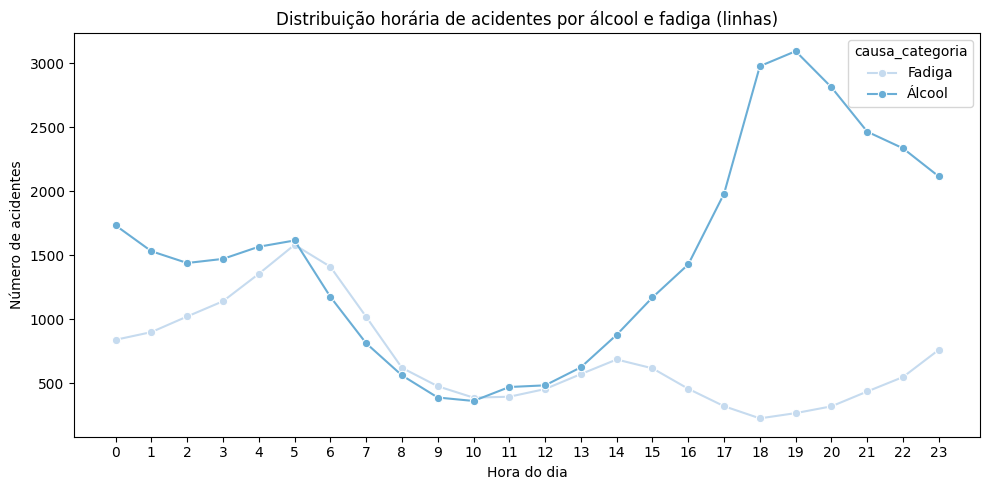

In [43]:
df_causas["hora"] = pd.to_datetime(df_causas["horario"], errors="coerce").dt.hour
df_group = df_causas.groupby(["hora","causa_categoria"]).size().reset_index(name="count")

plt.figure(figsize=(10,5))
sns.lineplot(
    data=df_group,
    x="hora",
    y="count",
    hue="causa_categoria",
    marker="o",
    palette=paleta_azul[:2]
)
plt.title("Distribuição horária de acidentes por álcool e fadiga (linhas)")
plt.xlabel("Hora do dia")
plt.ylabel("Número de acidentes")
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

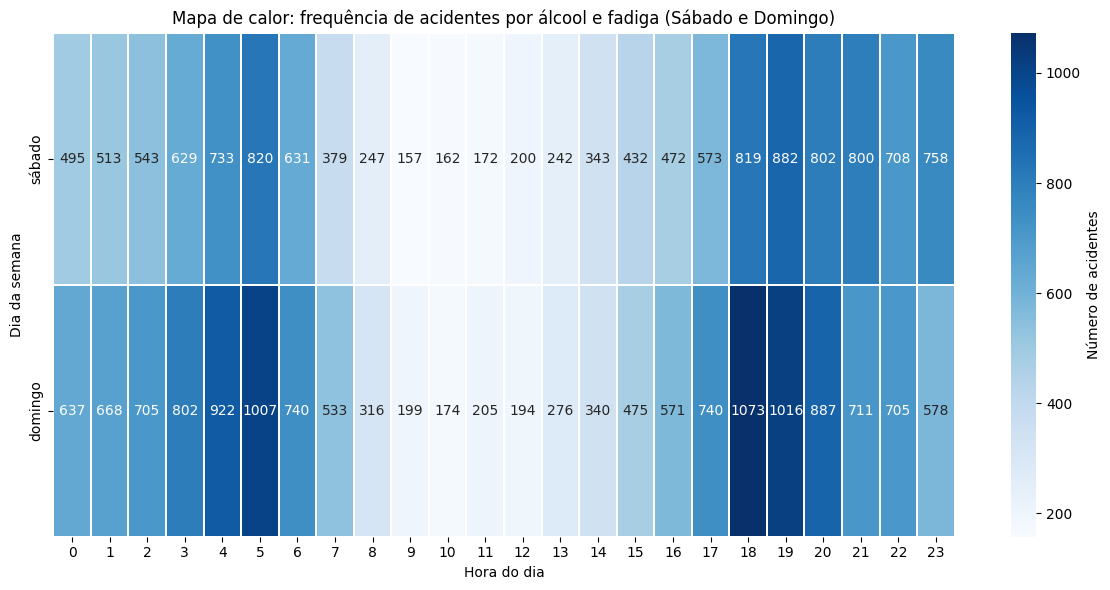

In [45]:
df_fds = df_causas[df_causas["dia_semana"].isin(["sábado", "domingo"])]
heatmap_data = df_fds.groupby(["dia_semana", "hora"]).size().unstack(fill_value=0)
heatmap_data = heatmap_data.reindex(["sábado", "domingo"])

plt.figure(figsize=(12,6))
sns.heatmap(
    heatmap_data,
    cmap="Blues",
    annot=True,
    fmt="d",
    linewidths=0.3,
    cbar_kws={"label": "Número de acidentes"}
)
plt.title("Mapa de calor: frequência de acidentes por álcool e fadiga (Sábado e Domingo)")
plt.xlabel("Hora do dia")
plt.ylabel("Dia da semana")
plt.tight_layout()
plt.show()


Tabela de contingência (frequências observadas):

causa_categoria  Fadiga  Outras  Álcool
final_semana                           
False             10759  283717   14583
True               6061  127107   20925

=== Teste Qui-Quadrado ===
Qui-quadrado: 11594.0378
p-valor: 0.000000
Graus de liberdade: 2

Frequências esperadas (se não houvesse diferença):

causa_categoria        Fadiga         Outras        Álcool
final_semana                                              
False            11223.901397  274140.788804  23694.309799
True              5596.098603  136683.211196  11813.690201


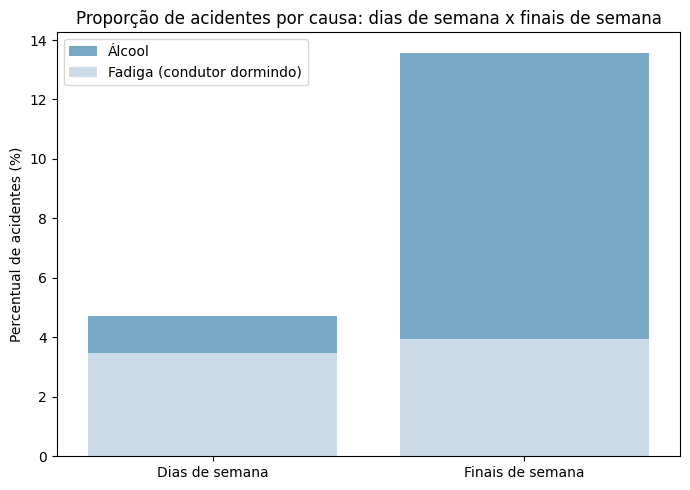


=== Interpretação ===
✅ Resultado: diferença estatisticamente significativa (p < 0.05)
Conclusão: finais de semana têm maior incidência de acidentes por álcool e fadiga.


In [49]:
from scipy.stats import chi2_contingency

# Paleta azul
paleta_azul = sns.color_palette("Blues", n_colors=3)

# Criar tabela de contingência
tabela = pd.crosstab(df["final_semana"], df["causa_categoria"])
print("\nTabela de contingência (frequências observadas):\n")
print(tabela)

# Teste Qui-Quadrado
chi2, p, dof, expected = chi2_contingency(tabela)
print("\n=== Teste Qui-Quadrado ===")
print(f"Qui-quadrado: {chi2:.4f}")
print(f"p-valor: {p:.6f}")
print(f"Graus de liberdade: {dof}")
print("\nFrequências esperadas (se não houvesse diferença):\n")
print(pd.DataFrame(expected, index=tabela.index, columns=tabela.columns))

# Gráfico de proporção: semana x fim de semana
proporcoes = (tabela.T / tabela.sum(axis=1)).T * 100

plt.figure(figsize=(7,5))
sns.barplot(
    x=proporcoes.index.map({False: "Dias de semana", True: "Finais de semana"}),
    y=proporcoes["Álcool"],
    color=paleta_azul[1],
    label="Álcool"
)
sns.barplot(
    x=proporcoes.index.map({False: "Dias de semana", True: "Finais de semana"}),
    y=proporcoes["Fadiga"],
    color=paleta_azul[0],
    label="Fadiga (condutor dormindo)"
)
plt.title("Proporção de acidentes por causa: dias de semana x finais de semana")
plt.ylabel("Percentual de acidentes (%)")
plt.xlabel("")
plt.legend()
plt.tight_layout()
plt.show()

# Interpretação automática
alpha = 0.05
print("\n=== Interpretação ===")
if p < alpha:
    print("✅ Resultado: diferença estatisticamente significativa (p < 0.05)")
    print("Conclusão: finais de semana têm maior incidência de acidentes por álcool e fadiga.")
else:
    print("❌ Resultado: diferença não significativa (p ≥ 0.05)")
    print("Conclusão: não há evidências suficientes para afirmar diferença entre semana e fim de semana.")